## Implements Gaussian on PM, NO, OZO dataframes that contain Landuse and Time

In [1]:
import math
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools import add_constant
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RationalQuadratic, DotProduct
import statsmodels.api as sm
sns.set(style="ticks")
import random
from matplotlib import pyplot as plt
import os
import pickle
import gpxpy.geo
%matplotlib inline

In [22]:
pm = pd.read_csv("merged_pmweather.csv")
no2 = pd.read_csv("merged_no2weather.csv")
so2 = pd.read_csv("merged_so2weather.csv")
bostonpm= pd.read_csv("boston_pm_LU_and_weather.csv")
#pm = pm.iloc[:, 3:]
no2 = no2.iloc[:, 3:]
so2 = so2.iloc[:, 3:]

def split_train_test(df, columns):
    train, test = train_test_split(df, random_state=0)
    x_train = train[columns].values
    y_train = train["ppm"].values
    x_test = test[columns].values
    y_test = test["ppm"].values
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_train_test(pm,['Sample Collection Start Time', 'forest', 'open_land', 'water',
       'wetland', 'transitional', 'urban_public_institution', 'commercial',
       'transportation', 'crop_land', 'medium_density_residential',
       'industrial', 'outdoor_temperature', 'solar_radiation',
       'wind_speed_resultant'])

## Gaussian function and plotting function

In [23]:
""" Creates Gaussian model, computs r squarred, MSE and log liklihood.
Given x_train, y_train, x_test, and y_test data, and numerical alpha value.
Prints train and test R^2. """

def gaussian(x_train, y_train, x_test, y_test, alpha):
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    kern =(0.004**2 ) *  RBF(length_scale=62)#C()*RBF(length_scale=2.12e+03)#(1.73**2)*RBF(length_scale = 2.18e+03)

    gp = GaussianProcessRegressor(kernel=kern, alpha=alpha, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=False, copy_X_train=False, random_state=None)
    gp.fit(x_train, y_train.reshape(train_size, 1))

    y_train_pred, sigma_train = gp.predict(x_train, return_std=True)
    y_test_pred, sigma_test = gp.predict(x_test, return_std=True)

    # get R^2
    r2 = gp.score(x_train, y_train.reshape(train_size, 1))
    r2_t = gp.score(x_test, y_test.reshape(test_size, 1))

    # get MSE measurements
    MSE_test = np.mean((y_test_pred - y_test.reshape(test_size, 1))**2)
    MSE_train = np.mean((y_train_pred - y_train.reshape(train_size, 1))**2)

    # get log likelihood
    #t=gp.log_marginal_likelihood()

    # calculate AIC
    #AIC = 2*len(x_test) - 2*np.log(-t)
    
    # print R^2 values
    print('mean squared error of train data with model = ' + str(MSE_train))
    print('mean squared error of test data with model = ' + str(MSE_test))
    #print('Akaike information criterion = ' + str(AIC))
    #print('log likelihood of model = ' + str(t))
    print (gp.kernel_)
    print('training R^2 value = ' + str(r2))
    print('testing R^2 value = ' + str(r2_t)), "\n \n"
    
    return y_train_pred, y_test_pred, gp

In [24]:
y_train_pred, y_test_pred, gp = gaussian(x_train, y_train, x_test, y_test, 0.001)

mean squared error of train data with model = 0.000979001163966
mean squared error of test data with model = 0.00100457217599
0.142**2 * RBF(length_scale=431)
training R^2 value = 0.205918750562
testing R^2 value = 0.198821360864


In [25]:
boston = pd.read_csv("final_boston.csv")
boston["Sample Collection Start Time"] = np.repeat(1, len(boston.index))
sites = boston["Site"]
boston = boston[['Sample Collection Start Time', 'commercial', 'crop_land', 'forest', 'industrial',
       'medium_density_residential', 'open_land', 'transitional',
       'transportation', 'urban_public_institution', 'water', 'wetland',
       'outdoor_temperature', 'wind_speed_resultant', 'solar_radiation']]
boston_aic_preds, sigma_preds = gp.predict(boston, return_std=True)
boston_aic_preds = [item for sublist in boston_aic_preds for item in sublist]
def parse_str(str_edit):
#   print str_edit
    str_edit = str_edit.replace('[', '')
    str_edit = str_edit.replace('(', '')
    str_edit = str_edit.replace(']', '')
    str_edit = str_edit.replace(')', '')
    str_edit = str_edit.replace(',', '')
    list = str_edit.split(' ')
#   print list
    return [[np.float64(list[0]), np.float64(list[1])], [np.float64(list[2]), np.float64(list[3])],
      [np.float64(list[4]), np.float64(list[5])], [np.float64(list[6]), np.float64(list[7])]]
min(sigma_preds*2)

0.012524538947521115

In [26]:
loc = []
for i in sites:
    loc.append(parse_str(i))
lats, longs = [], []
for i in np.arange(len(loc)):
    lats.append((loc[i][0][0], loc[i][0][1], boston_aic_preds[i], sigma_preds[i]))
    #longs.append(i[0][1])
w = pd.DataFrame(pd.Series(lats))
w.to_csv("boston_pm_Gauss_preds.csv", index=False)
#w.to_json("boston_so2_Gauss_preds.json")

In [27]:
pd.read_csv("boston_pm_Gauss_preds.csv")["0"][0]
#pd.read_csv("boston_pm_Gauss_preds.csv")["0"][0]

'(-71.201970000000003, 42.291440999999999, 0.018767772587720444, 0.006536824743604959)'

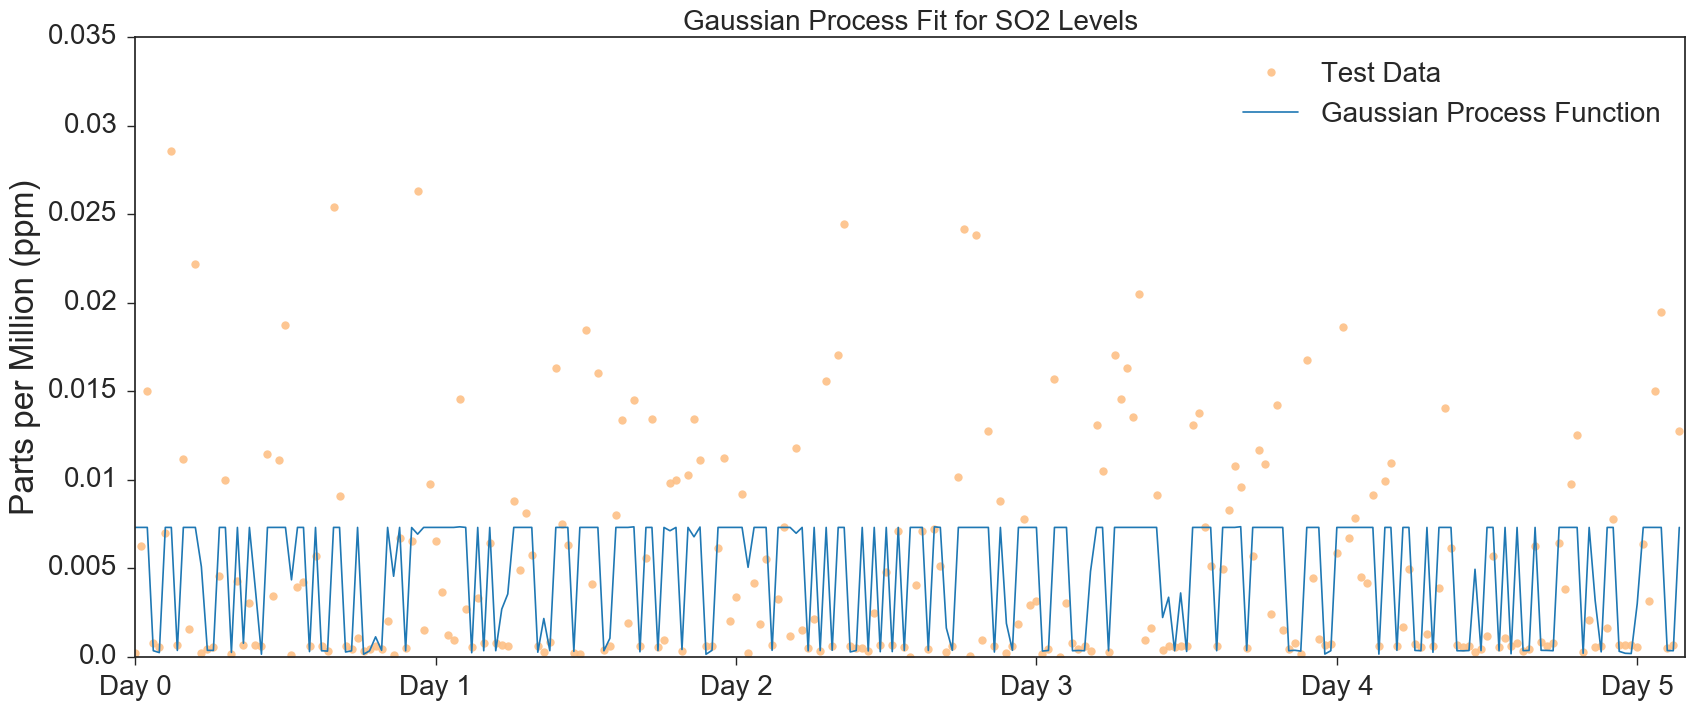

In [106]:
flat_list = [item for sublist in y_test_pred for item in sublist]
x = np.arange(0, len(flat_list), 1)
plt.figure(figsize=(20, 8))
plt.plot(x, y_test, ".", color="#fdc086", alpha=0.9, markersize=12, label='Test Data')
plt.plot(x, y_test_pred, color="#1f78b4", linewidth=1.2, label="Gaussian Process Function")
plt.axis([0, len(y_test), 0, 0.035])
plt.ylabel('Parts per Million (ppm)', fontsize=24)
plt.title('Gaussian Process Fit for SO2 Levels', fontsize=20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    top='off')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    right='off',# ticks along the top edge are off
    labelbottom='off')
plt.xticks(np.arange(0, 300, 50), ("Day 0", "Day 1", "Day 2", "Day 3", "Day 4", "Day 5"), fontsize=20)
plt.yticks(np.arange(0, 0.035, 0.005), np.arange(0, 0.035, 0.005), fontsize=20)
plt.legend(fontsize=20)
plt.show()


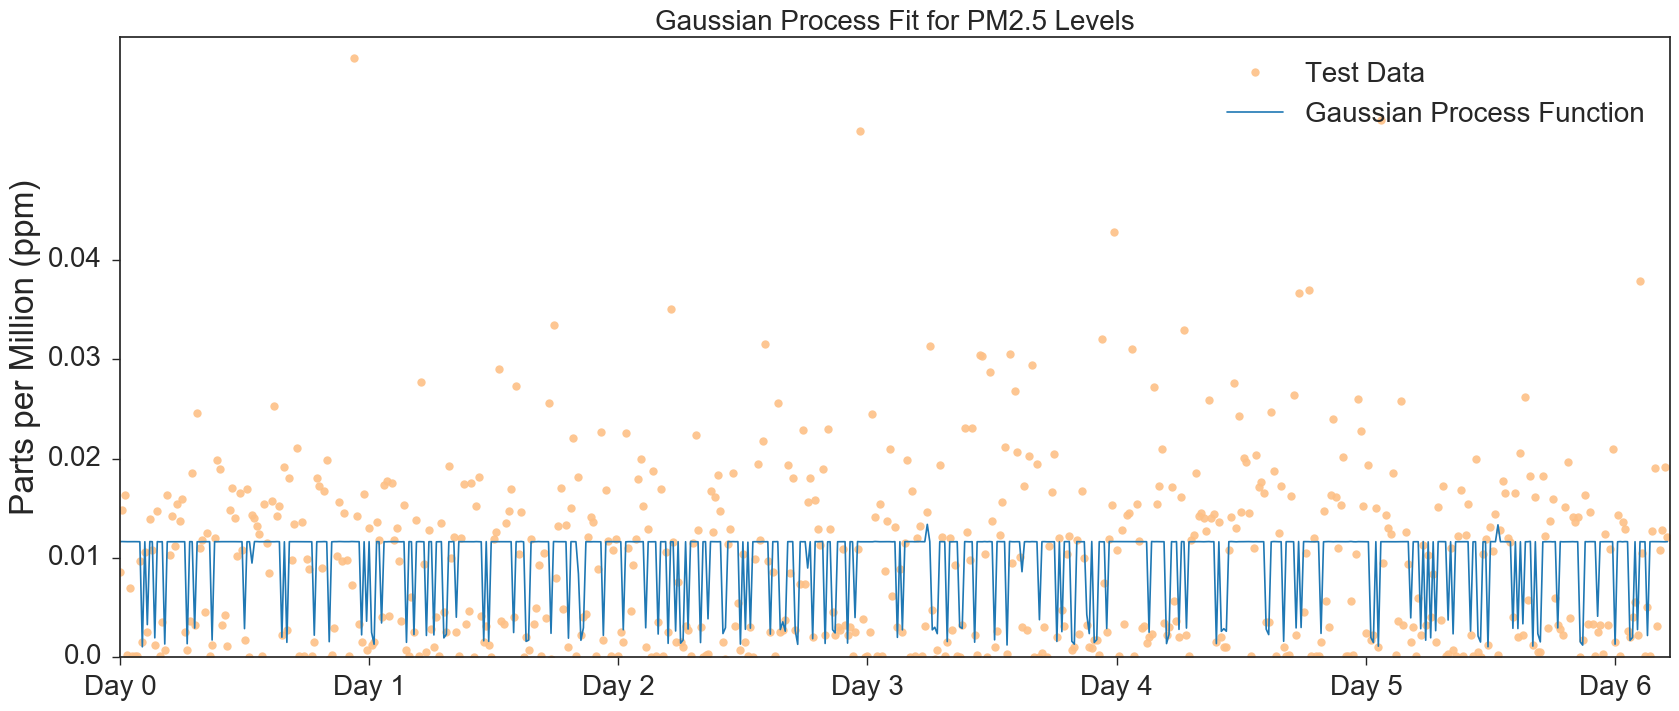

In [69]:
flat_list = [item for sublist in y_test_pred for item in sublist]
x = np.arange(0, len(flat_list), 1)
plt.figure(figsize=(20, 8))
plt.plot(x, y_test, ".", color="#fdc086", alpha=0.9, markersize=12, label='Test Data')
plt.plot(x, y_test_pred, color="#1f78b4", linewidth=1.2, label="Gaussian Process Function")
plt.axis([0, len(y_test), 0, 0.25])
plt.ylabel('Parts per Million (ppm)', fontsize=24)
plt.title('Gaussian Process Fit for PM2.5 Levels', fontsize=20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    top='off')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    right='off',# ticks along the top edge are off
    labelbottom='off')
plt.xticks(np.arange(0, 700, 100), ("Day 0", "Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6"), fontsize=20)
plt.yticks(np.arange(0, 0.20, 0.04), np.arange(0, 0.20, 0.01), fontsize=20)
plt.legend(fontsize=20)
plt.show()


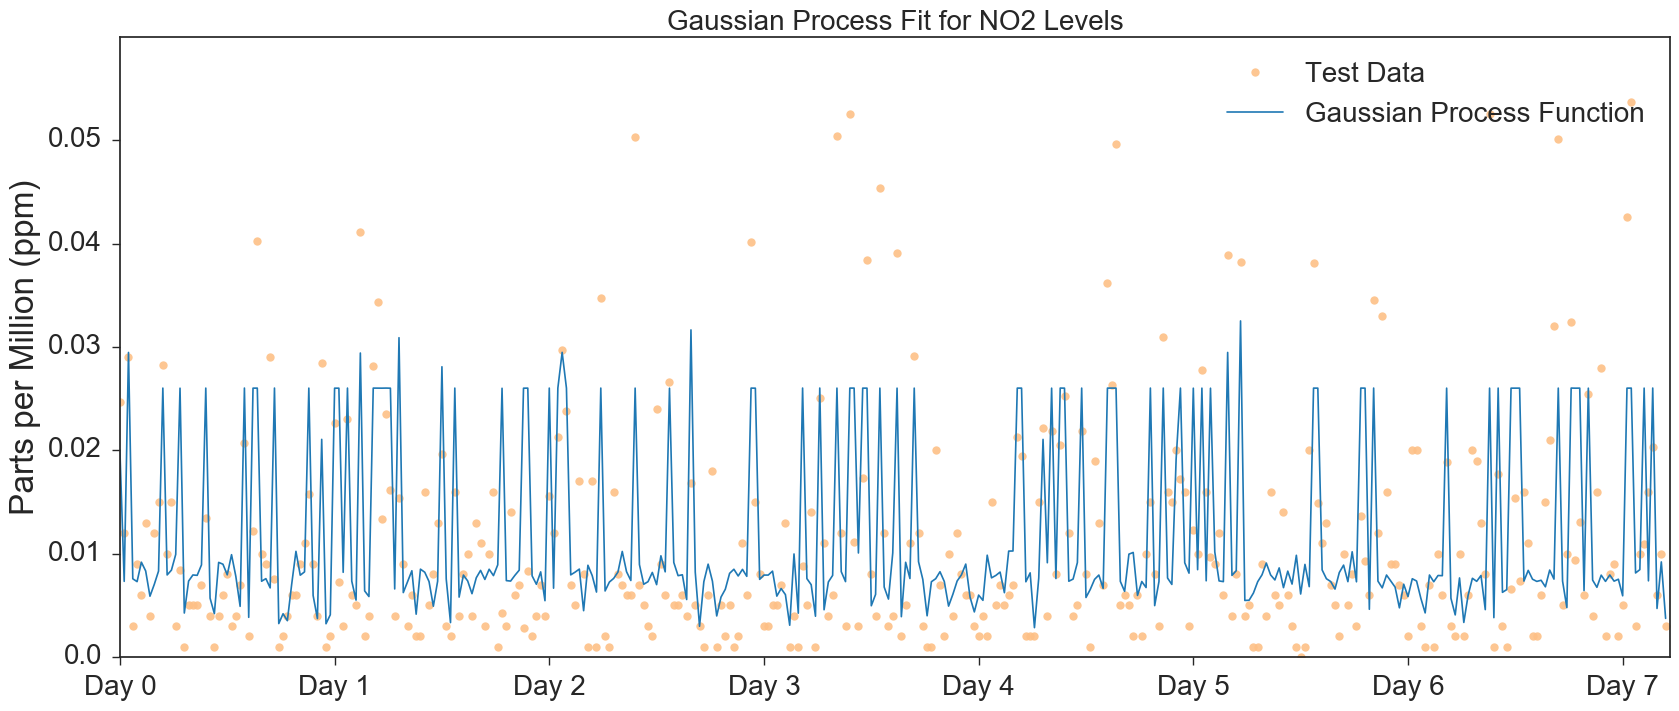

In [83]:
flat_list = [item for sublist in y_test_pred for item in sublist]
x = np.arange(0, len(flat_list), 1)
plt.figure(figsize=(20, 8))
plt.plot(x, y_test, ".", color="#fdc086", alpha=0.9, markersize=12, label='Test Data')
plt.plot(x, y_test_pred, color="#1f78b4", linewidth=1.2, label="Gaussian Process Function")
plt.axis([0, len(y_test), 0, 0.06])
plt.ylabel('Parts per Million (ppm)', fontsize=24)
plt.title('Gaussian Process Fit for NO2 Levels', fontsize=20)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    top='off')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected,      # ticks along the bottom edge are off
    right='off',# ticks along the top edge are off
    labelbottom='off')
plt.xticks(np.arange(0, 351, 50), ("Day 0", "Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7"), fontsize=20)
plt.yticks(np.arange(0, 0.06, 0.01), np.arange(0, 0.06, 0.01), fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Running Gaussian on Boston PM
#### Pickles Boston PM data frame with land use and weather columns

In [ ]:
x_label = 'Time'
y_label = 'Pollutant'

alpha = 0.0608

x_train, x_test, y_train, y_test = split_train_test(aq_df2, all_columns)
y_train_pred, y_test_pred, gp = gaussian(x_train, y_train, x_test, y_test, alpha)

## NO

In [ ]:
no_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/appendedNO.csv")

no_lat = no_df["Latitude"]
no_lon = no_df["Longitude"]

no_df['lat_lon'] = list(zip(no_lat, no_lon))
no_lat_lon_pts = no_df['lat_lon']
del no_df['lat_lon']

NO_width = no_df.shape[1]
LU_width = df_w_cells.shape[1]
no_df = add_columns(no_df)

In [ ]:
#Don't need to run again, as I already wrote it to a csv later on
no_df = update_df_w_landuse(no_lat_lon_pts, cells, no_df, df_w_cells, col_names)
print("done")

In [ ]:
#Don't need to run again
no_df = update_df_w_weather(no_lat_lon_pts, no_df, df_w_weather, weather_col_names)
print("done")

In [ ]:
no_df.to_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_NO_LU_and_weather.csv")

In [ ]:
no_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_NO_LU_and_weather.csv")
no_df2 = pickle_df(no_df)

In [ ]:
alpha = 0.00007

x_train, x_test, y_train, y_test = split_train_test(no_df2, all_columns)
y_train_pred, y_test_pred, gp = gaussian(x_train, y_train, x_test, y_test, alpha)

## OZO Data frame

In [ ]:
ozo_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/appendedOZO.csv")

ozo_lat = ozo_df["Latitude"]
ozo_lon = ozo_df["Longitude"]

ozo_df['lat_lon'] = list(zip(ozo_lat, ozo_lon))
ozo_lat_lon_pts = ozo_df['lat_lon']
del ozo_df['lat_lon']

OZO_width = ozo_df.shape[1]
LU_width = df_w_cells.shape[1]
ozo_df = add_columns(ozo_df)

In [ ]:
ozo_df = update_df_w_landuse(ozo_lat_lon_pts, cells, ozo_df, df_w_cells, col_names)
print("done")

In [ ]:
ozo_df = update_df_w_weather(ozo_lat_lon_pts, ozo_df, df_w_weather, weather_col_names)
print("done")

In [ ]:
ozo_df.to_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_ozo_LU_and_weather.csv")

In [ ]:
ozo_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_ozo_LU_and_weather.csv")
ozo_df2 = pickle_df(ozo_df)

In [ ]:
alpha = 0.00009

x_train, x_test, y_train, y_test = split_train_test(ozo_df2, all_columns)
y_train_pred, y_test_pred, gp = gaussian(x_train, y_train, x_test, y_test, alpha)

## SO

In [ ]:
so_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/appendedSO.csv")

so_lat = so_df["Latitude"]
so_lon = so_df["Longitude"]

so_df['lat_lon'] = list(zip(so_lat, so_lon))
so_lat_lon_pts = so_df['lat_lon']
del so_df['lat_lon']

SO_width = so_df.shape[1]
LU_width = df_w_cells.shape[1]
so_df = add_columns(so_df)

In [ ]:
so_df = update_df_w_landuse(so_lat_lon_pts, cells, so_df, df_w_cells, col_names)
print("done")

In [ ]:
so_df = update_df_w_weather(so_lat_lon_pts, so_df, df_w_weather, weather_col_names)
print("done")

In [ ]:
so_df.to_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_so_LU_and_weather.csv")

In [ ]:
so_df = pd.read_csv("C:/Users/Anthony DePinho/Documents/REU 2017/TRiCAM_BostonAQ/Gaussian_Data/boston_so_LU_and_weather.csv")
so_df2 = pickle_df(so_df)

In [ ]:
alpha = 0.0001

x_train, x_test, y_train, y_test = split_train_test(so_df2, all_columns)
y_train_pred, y_test_pred, gp = gaussian(x_train, y_train, x_test, y_test, alpha)